In [2]:
%cd /content/drive/MyDrive/ECE147-Final-Project/

/content/drive/MyDrive/ECE147-Final-Project


In [ ]:
%pip install -r requirements.txt

# Initialize

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary

from utils.dataset import EEGDataset
from prepare_data import get_raw_dataloader, get_sub1_dataloader, get_frequency_dataloader, get_time_series_dataloader
from utils.training import best_torch_device, train

In [6]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [7]:
%load_ext autoreload
%autoreload 2

## Constants

In [10]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [11]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [12]:
train_data[RAW], valid_data[RAW], test_data[RAW] = get_raw_dataloader()

In [13]:
print("Training set shape:", train_data[RAW].dataset.X.shape)
print("Validation set shape:", valid_data[RAW].dataset.X.shape)
print("Test set shape:", test_data[RAW].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


### Sub1 Data

In [14]:
train_data[SUB1], valid_data[SUB1], test_data[SUB1] = get_sub1_dataloader()

In [15]:
print("Training set shape:", train_data[SUB1].dataset.X.shape)
print("Validation set shape:", valid_data[SUB1].dataset.X.shape)
print("Test set shape:", test_data[SUB1].dataset.X.shape)

Training set shape: (199, 22, 1000)
Validation set shape: (38, 22, 1000)
Test set shape: (50, 22, 1000)


### Frequency Data

In [16]:
train_data[FREQ], valid_data[FREQ], test_data[FREQ] = get_frequency_dataloader()

In [17]:
print("Training set shape:", train_data[FREQ].dataset.X.shape)
print("Validation set shape:", valid_data[FREQ].dataset.X.shape)
print("Test set shape:", test_data[FREQ].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


# Model

In [98]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        # self.dropout = nn.Dropout(0.2)
        self.downsample = downsample
        self.elu = nn.ELU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.elu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 50, kernel_size=70, stride=1, padding=35)
        self.bn = nn.BatchNorm1d(50)
        self.elu = nn.ELU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.elu = nn.ELU()
        self.layer1 = ResidualBlock(50, 22, stride=2, downsample=nn.Sequential(
                                      nn.Conv1d(50, 22, kernel_size=1, stride=2),
                                      nn.BatchNorm1d(22)))
        self.layer2 = ResidualBlock(22, 24, stride=2, downsample=nn.Sequential(
                                      nn.Conv1d(22, 24, kernel_size=1, stride=2),
                                      nn.BatchNorm1d(24)))
        # self.layer3 = ResidualBlock(90, 90)
        # self.layer4 = ResidualBlock(256, 256)
        self.avg_pool = nn.AdaptiveAvgPool1d(12)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(24 * 12, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.bn(x)
        x = self.elu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        # x = self.layer5(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [99]:
test_model = ResNet(in_channels=22, num_classes=4)
test_model.to(DEVICE)
test_model.forward(torch.rand(2, 22, 1000).to(DEVICE))
_ = summary(test_model, (22, 1000), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 50, 1001]            77,050
├─BatchNorm1d: 1-2                       [-1, 50, 1001]            100
├─ELU: 1-3                               [-1, 50, 1001]            --
├─MaxPool1d: 1-4                         [-1, 50, 501]             --
├─Dropout: 1-5                           [-1, 50, 501]             --
├─ResidualBlock: 1-6                     [-1, 22, 251]             --
|    └─Conv1d: 2-1                       [-1, 22, 251]             3,322
|    └─BatchNorm1d: 2-2                  [-1, 22, 251]             44
|    └─ELU: 2-3                          [-1, 22, 251]             --
|    └─Conv1d: 2-4                       [-1, 22, 251]             1,474
|    └─BatchNorm1d: 2-5                  [-1, 22, 251]             44
|    └─Sequential: 2-6                   [-1, 22, 251]             --
|    |    └─Conv1d: 3-1                  [-1, 22, 251]             1,122
|

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [100]:
raw_model = ResNet(in_channels=22, num_classes=4)
raw_model.to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=100,
    cp_path="models/resnet",
    cp_filename="raw.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: cuda
[Epoch 0] val_acc=0.352071 train_acc=0.291503 val_loss=0.023409 train_loss=0.021922
Validation loss decreased (inf --> 0.023409).  Saving model ...
[Epoch 1] val_acc=0.414201 train_acc=0.379291 val_loss=0.022517 train_loss=0.020883
Validation loss decreased (0.023409 --> 0.022517).  Saving model ...
[Epoch 2] val_acc=0.464497 train_acc=0.454136 val_loss=0.021360 train_loss=0.019892
Validation loss decreased (0.022517 --> 0.021360).  Saving model ...
[Epoch 3] val_acc=0.488166 train_acc=0.485650 val_loss=0.020982 train_loss=0.019313
Validation loss decreased (0.021360 --> 0.020982).  Saving model ...
[Epoch 4] val_acc=0.511834 train_acc=0.525605 val_loss=0.019918 train_loss=0.018664
Validation loss decreased (0.020982 --> 0.019918).  Saving model ...
[Epoch 5] val_acc=0.482249 train_acc=0.551491 val_loss=0.020243 train_loss=0.018476
EarlyStopping counter: 1 out of 100
[Epoch 6] val_acc=0.500000 train_acc=0.565560 val_loss=0.019116 train_loss=0.017862
Validation loss d

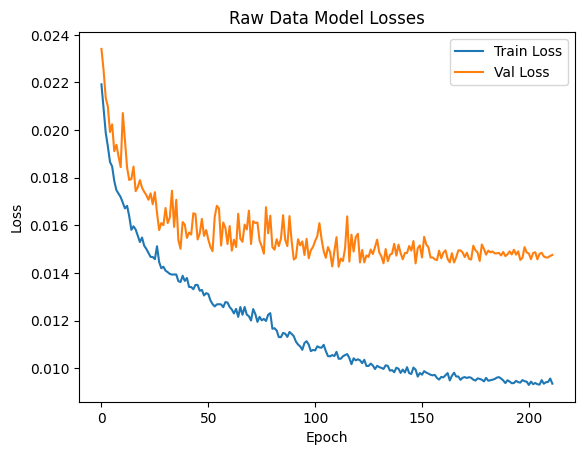

In [101]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

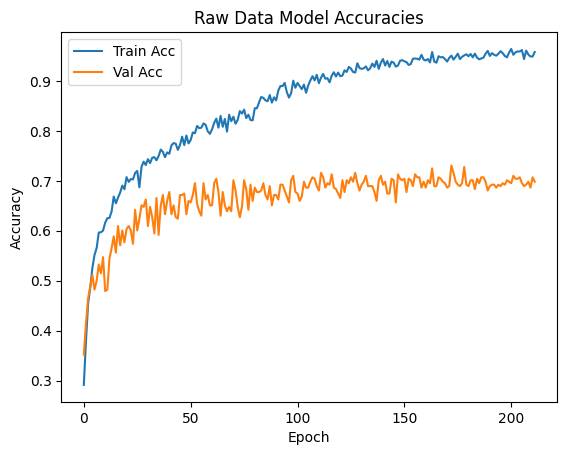

In [102]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [103]:
# Load best model and test
raw_model = torch.load("models/resnet/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

ResNet(
  (initial_conv): Conv1d(22, 50, kernel_size=(70,), stride=(1,), padding=(35,))
  (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv1d(50, 22, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(22, 22, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv1d(50, 22, kernel_size=(1,), stride=(2,))
      (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (elu): ELU(alpha=1.0)
  )
  (layer2): ResidualBlock(
    (conv1): Conv1d(22, 24, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momen

In [104]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.7020


In [105]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.7800


## Sub1 Data    

In [126]:
sub1_model = ResNet(in_channels=22, num_classes=4)
sub1_model.to(DEVICE)

optimizer = torch.optim.Adam(sub1_model.parameters(), lr=0.001, weight_decay=0.15)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=7, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub1_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=80,
    cp_path="models/resnet",
    cp_filename="sub1.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: cuda
[Epoch 0] val_acc=0.263158 train_acc=0.201005 val_loss=0.036910 train_loss=0.027871
Validation loss decreased (inf --> 0.036910).  Saving model ...
[Epoch 1] val_acc=0.289474 train_acc=0.386935 val_loss=0.036733 train_loss=0.027005
Validation loss decreased (0.036910 --> 0.036733).  Saving model ...
[Epoch 2] val_acc=0.263158 train_acc=0.351759 val_loss=0.036540 train_loss=0.027501
Validation loss decreased (0.036733 --> 0.036540).  Saving model ...
[Epoch 3] val_acc=0.289474 train_acc=0.396985 val_loss=0.036395 train_loss=0.026766
Validation loss decreased (0.036540 --> 0.036395).  Saving model ...
[Epoch 4] val_acc=0.263158 train_acc=0.417085 val_loss=0.036392 train_loss=0.027104
Validation loss decreased (0.036395 --> 0.036392).  Saving model ...
[Epoch 5] val_acc=0.236842 train_acc=0.396985 val_loss=0.036415 train_loss=0.026317
EarlyStopping counter: 1 out of 80
[Epoch 6] val_acc=0.315789 train_acc=0.467337 val_loss=0.036246 train_loss=0.025936
Validation loss de

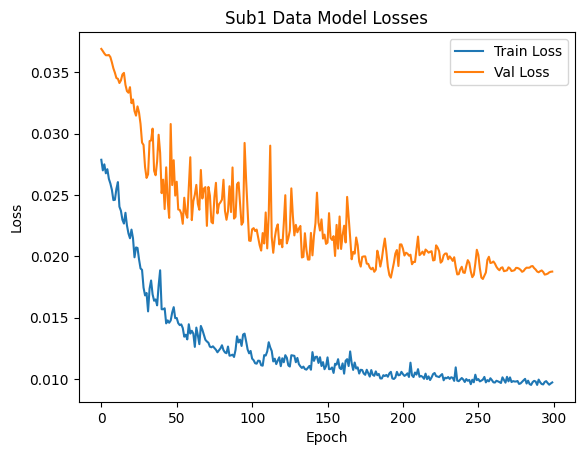

In [127]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

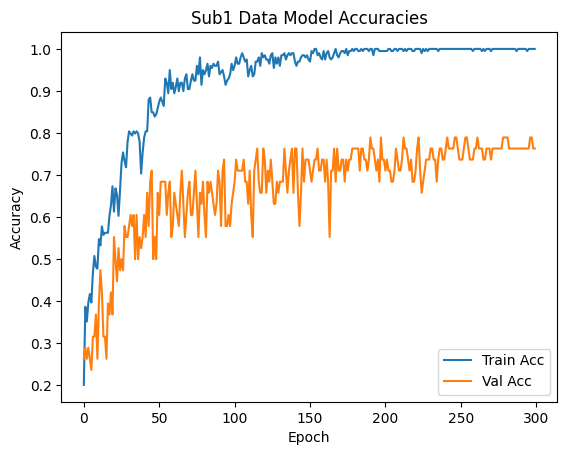

In [128]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [129]:
# Load best model and test
sub1_model = torch.load("models/resnet/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

ResNet(
  (initial_conv): Conv1d(22, 50, kernel_size=(70,), stride=(1,), padding=(35,))
  (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv1d(50, 22, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(22, 22, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv1d(50, 22, kernel_size=(1,), stride=(2,))
      (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (elu): ELU(alpha=1.0)
  )
  (layer2): ResidualBlock(
    (conv1): Conv1d(22, 24, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momen

In [130]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.7000


In [131]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.3499


## Frequency Data

In [132]:
freq_model = ResNet(in_channels=22, num_classes=4)
freq_model.to(DEVICE)

optimizer = torch.optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=freq_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=80,
    cp_path="models/resnet",
    cp_filename="freq.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: cuda
[Epoch 0] val_acc=0.316568 train_acc=0.249859 val_loss=0.024189 train_loss=0.022259
Validation loss decreased (inf --> 0.024189).  Saving model ...
[Epoch 1] val_acc=0.325444 train_acc=0.299381 val_loss=0.024080 train_loss=0.021824
Validation loss decreased (0.024189 --> 0.024080).  Saving model ...
[Epoch 2] val_acc=0.328402 train_acc=0.293754 val_loss=0.023925 train_loss=0.021745
Validation loss decreased (0.024080 --> 0.023925).  Saving model ...
[Epoch 3] val_acc=0.328402 train_acc=0.292628 val_loss=0.023657 train_loss=0.021823
Validation loss decreased (0.023925 --> 0.023657).  Saving model ...
[Epoch 4] val_acc=0.363905 train_acc=0.307259 val_loss=0.023692 train_loss=0.021668
EarlyStopping counter: 1 out of 80
[Epoch 5] val_acc=0.381657 train_acc=0.346652 val_loss=0.023543 train_loss=0.021569
Validation loss decreased (0.023657 --> 0.023543).  Saving model ...
[Epoch 6] val_acc=0.372781 train_acc=0.311761 val_loss=0.023198 train_loss=0.021559
Validation loss de

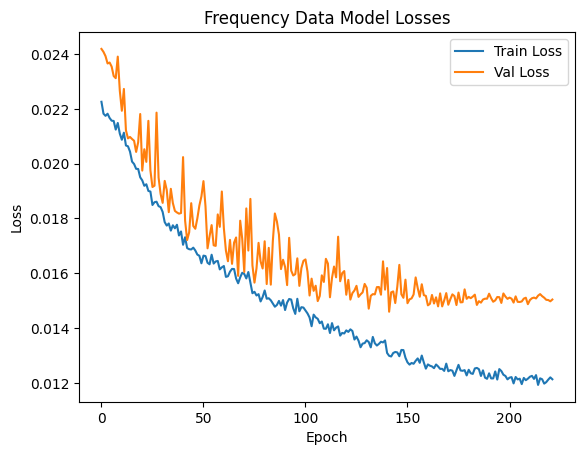

In [133]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

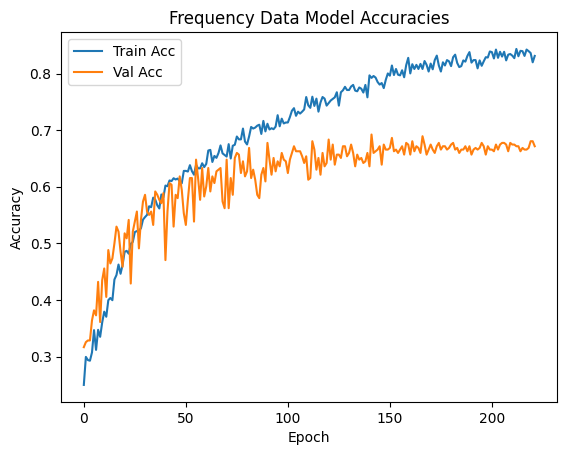

In [134]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [135]:
# Load best model and test
freq_model = torch.load("models/resnet/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

ResNet(
  (initial_conv): Conv1d(22, 50, kernel_size=(70,), stride=(1,), padding=(35,))
  (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv1d(50, 22, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(22, 22, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv1d(50, 22, kernel_size=(1,), stride=(2,))
      (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (elu): ELU(alpha=1.0)
  )
  (layer2): ResidualBlock(
    (conv1): Conv1d(22, 24, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momen

In [136]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.6343


## Time Series

In [137]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [138]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    train_data, valid_data, test_data = get_time_series_dataloader(ts)

    time_model = ResNet(in_channels=22, num_classes=4)
    time_model.to(DEVICE)

    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=30,
        cp_path="models/resnet",
        cp_filename=f"time_{ts}.pt",
        n_epochs=100,
        show_progress_bar=False,
    )

    # Load best model and test
    time_model = torch.load(f"models/resnet/time_{ts}.pt")
    time_model.to(DEVICE)
    time_model.eval()

    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)

    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)

Using device: cuda
[Epoch 0] val_acc=0.328402 train_acc=0.267304 val_loss=0.024057 train_loss=0.023987
Validation loss decreased (inf --> 0.024057).  Saving model ...
[Epoch 1] val_acc=0.316568 train_acc=0.316263 val_loss=0.023920 train_loss=0.022322
Validation loss decreased (0.024057 --> 0.023920).  Saving model ...
[Epoch 2] val_acc=0.334320 train_acc=0.318514 val_loss=0.023504 train_loss=0.021802
Validation loss decreased (0.023920 --> 0.023504).  Saving model ...
[Epoch 3] val_acc=0.328402 train_acc=0.348340 val_loss=0.023494 train_loss=0.021471
Validation loss decreased (0.023504 --> 0.023494).  Saving model ...
[Epoch 4] val_acc=0.322485 train_acc=0.353405 val_loss=0.023698 train_loss=0.021394
EarlyStopping counter: 1 out of 30
[Epoch 5] val_acc=0.355030 train_acc=0.382667 val_loss=0.023286 train_loss=0.020913
Validation loss decreased (0.023494 --> 0.023286).  Saving model ...
[Epoch 6] val_acc=0.396450 train_acc=0.380979 val_loss=0.022858 train_loss=0.020862
Validation loss de

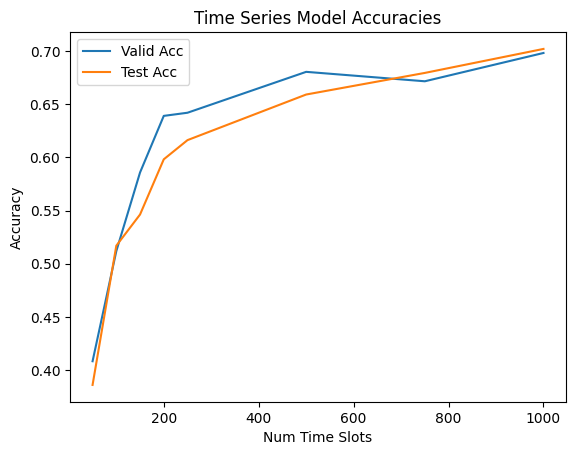

In [139]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()